# Electric Waltz

## Imports

In [113]:
# Standard imports

import csv
from typing import cast, Optional, Sequence

from pandas import DataFrame, read_csv
from ruamel.yaml import YAML

In [114]:
# Add parent dir to the path, so we can load the module

import os, sys
sys.path.append(os.path.dirname(os.path.abspath('')))

In [115]:
# Load stuff from the module

from electric_waltz.cross_border import CrossBorderTerminal
from electric_waltz.dispatch import SourceDispatcher, StorageDispatcher
from electric_waltz.scenario import Scenario, ScenarioRun
from electric_waltz.source import (
    DispatchableSource,
    NonDispatchableSource,
    PowerSource,
)
from electric_waltz.storage import EnergyStorage
from electric_waltz.types import Energy, Power

In [116]:
# Load some helper functions from main script, to avoid code duplicities

from main import make_power_plant, make_storage

## Parameters

In [117]:
input_path = 'input_data.csv'
config_path = 'configs/present.yml'
output_path = 'model_output.csv'
year = 2021

In [118]:
world = read_csv(input_path)
world = world[world["year"] == year].reset_index(drop=True)

In [119]:
with open(config_path, encoding="utf-8") as config_file:
    yaml = YAML(typ="safe")
    config = yaml.load(config_file)

In [120]:
world.head()

,datetime,year,month,day,hour,solar_util,wind_util,load
0,2020-12-31T23:00:00Z,2021,1,1,0,0.0,0.200354,6017
1,2021-01-01T00:00:00Z,2021,1,1,1,0.0,0.191514,5952
2,2021-01-01T01:00:00Z,2021,1,1,2,0.0,0.167943,5942
3,2021-01-01T02:00:00Z,2021,1,1,3,0.0,0.223925,5839
4,2021-01-01T03:00:00Z,2021,1,1,4,0.0,0.206246,5845


In [121]:
config

{'plants': {'installed': {'nuclear': 4290,
   'pv': 2061,
   'wind': 339,
   'hydro': 1094,
   'biomass': 1193,
   'coal': 9802,
   'gas': 1714},
  'self_consumption': {'nuclear': 0.055,
   'pv': 0.0089,
   'wind': 0.0129,
   'hydro': 0.008,
   'biomass': 0.0926,
   'coal': 0.0994,
   'gas': 0.03}},
 'storage': {'installed': {'pumped': 1170, 'battery': 0, 'p2g': 0},
  'max_energy': {'pumped': 6260, 'battery': 0, 'p2g': 0},
  'efficiency': {'pumped': 0.7676, 'battery': 0.85, 'p2g': 0.38}},
 'cross_border': {'max_export': 2000},
 'consumption': {'transmission_loss': 0.02,
  'distribution_loss': 0.0503,
  'load_multiplier': 1.0}}

## Simulation

In [122]:
if "load_multiplier" in config["consumption"]:
    load_multiplier = float(config["consumption"]["load_multiplier"])
    world.load *= load_multiplier

grid_losses: float = (
    config["consumption"]["transmission_loss"]
    + config["consumption"]["distribution_loss"]
)

# Inflexible power plants.
nuclear = cast(NonDispatchableSource, make_power_plant("nuclear", config))
pv = cast(NonDispatchableSource, make_power_plant("pv", config))
wind = cast(NonDispatchableSource, make_power_plant("wind", config))

# Flexible power plants.
hydro = cast(DispatchableSource, make_power_plant("hydro", config))
biomass = cast(DispatchableSource, make_power_plant("biomass", config))
coal = cast(DispatchableSource, make_power_plant("coal", config))
gas = cast(DispatchableSource, make_power_plant("gas", config))

# Electricity storage.
pumped = make_storage("pumped", config)
battery = make_storage("battery", config)
p2g = make_storage("p2g", config)

# Cross-border import/export.
cross_border = CrossBorderTerminal(config["cross_border"]["max_export"])

In [123]:
# Construct the scenario object and run the simulation.
scenario = Scenario(
    load=world.load,
    baseload_sources=[nuclear],
    intermittent_sources=[
        (pv, world.solar_util),
        (wind, world.wind_util),
    ],
    flexible_sources=[hydro, biomass, coal, gas],
    storage_units=[pumped, battery, p2g],
    cross_border=cross_border,
    grid_losses=grid_losses,
)

stats = scenario.run()

In [124]:
total_consumption = sum(world.load)
total_flexible_generation = (
    stats.compute_generation("hydro")
    + stats.compute_generation("biomass")
    + stats.compute_generation("gas")
)
total_inflexible_generation = (
    stats.compute_generation("nuclear")
    + stats.compute_generation("pv")
    + stats.compute_generation("wind")
)
total_generation = total_flexible_generation + total_inflexible_generation

total_charging = stats.compute_total_charging()
total_discharging = stats.compute_total_discharging()

total_export = stats.compute_total_export()
total_import = stats.compute_total_import()

total_dump = stats.compute_total_dump()
total_shortage = stats.compute_total_shortage()

charging_hours = stats.count_charging_steps()
discharging_hours = stats.count_discharging_steps()
export_hours = stats.count_export_steps()
import_hours = stats.count_import_steps()
dump_hours = stats.count_dump_steps()
shortage_hours = stats.count_shortage_steps()

print(f"Total net generation         {total_generation:12,.0f} MWh")
print(f"├─ Total inflexible          {total_inflexible_generation:12,.0f}")
print("│  ├─ Nuclear                {:12,.0f}".format(stats.compute_generation("nuclear")))
print("│  ├─ Solar PV               {:12,.0f}".format(stats.compute_generation("pv")))
print("│  └─ On-shore wind          {:12,.0f}".format(stats.compute_generation("wind")))
print(f"└─ Total flexible            {total_flexible_generation:12,.0f}")
print("   ├─ Hydro                  {:12,.0f}".format(stats.compute_generation("hydro")))
print("   ├─ Biomass                {:12,.0f}".format(stats.compute_generation("biomass")))
print("   └─ Coal                   {:12,.0f}".format(stats.compute_generation("coal")))
print("   └─ Natural gas            {:12,.0f}".format(stats.compute_generation("gas")))

print(f"\nTotal charging consumption   {total_charging:12,.0f} MWh "
      f"{charging_hours:6d} hrs")
print(f"Total discharging            {total_discharging:12,.0f}     "
      f"{discharging_hours:6d} hrs")
print(f"\nTotal export                 {total_export:12,.0f}     "
      f"{export_hours:6d} hrs")
print(f"Total import                 {total_import:12,.0f}     "
      f"{import_hours:6d} hrs")
print(f"Import balance               {total_import-total_export:12,.0f}")

print(f"\nTotal surplus/dump           {total_dump:12,.0f}     "
      f"{dump_hours:6d} hrs")
print(f"Total shortage (EENS/LOLE)   {total_shortage:12,.0f}     "
      f"{shortage_hours:6d} hrs")

print(f"\nTotal net consumption        {total_consumption:12,.0f} MWh")

breakpoint

model_output = DataFrame(data={
    "nuclear": stats._source_generation["nuclear"],
    "pv": stats._source_generation["pv"],
    "wind": stats._source_generation["wind"],
    "biomass": stats._source_generation["biomass"],
    "hydro": stats._source_generation["hydro"],
    "coal": stats._source_generation["coal"],
    "gas": stats._source_generation["gas"],
    "pumped": stats._storage_output["pumped"],
    "battery": stats._storage_output["battery"],
    "p2g": stats._storage_output["p2g"],
    "import": stats._net_import,
    "shortage": stats._shortage,
})
model_output.to_csv(output_path, index_label="ix")

print(f"\nModel output written to ‘sandbox/{output_path}’")

Total net generation           56,789,001 MWh
├─ Total inflexible            38,262,916
│  ├─ Nuclear                  35,513,478
│  ├─ Solar PV                  2,147,111
│  └─ On-shore wind               602,327
└─ Total flexible              18,526,085
   ├─ Hydro                     9,500,899
   ├─ Biomass                   9,025,186
   └─ Coal                     14,535,671
   └─ Natural gas                       0

Total charging consumption             -0 MWh      0 hrs
Total discharging                       0          0 hrs

Total export                           -0          0 hrs
Total import                            0          0 hrs
Import balance                          0

Total surplus/dump                      0          0 hrs
Total shortage (EENS/LOLE)              0          0 hrs

Total net consumption          66,639,887 MWh

Model output written to ‘sandbox/model_output.csv’


## Report

Měli bychom přidat `matplotlib` a `seaborn` do requirements.txt? A možná i `jupyterlab`?

In [125]:
!pip install matplotlib
!pip install seaborn

zsh:1: command not found: pip
zsh:1: command not found: pip


In [126]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 12, 8

In [127]:
df = pd.concat([world, model_output], axis=1)

In [128]:
# df['dt'] = df.index * pd.Timedelta(hours=1) + pd.Timestamp('00:00:00 2050-01-01')
df['dt'] = pd.to_datetime(df['datetime'])
df['storage'] = df['pumped'] + df['battery'] + df['p2g']
df = df.set_index('dt')

In [129]:
df.head()

,datetime,year,month,day,hour,solar_util,wind_util,load,nuclear,pv,...,biomass,hydro,coal,gas,pumped,battery,p2g,import,shortage,storage
dt,,,,,,,,,,,,,,,,,,,,,
2020-12-31 23:00:00+00:00,2020-12-31T23:00:00Z,2021,1,1,0,0.0,0.200354,6017.0,4054.05,0.0,...,1082.528200,1085.248,151.125208,0.0,0.0,0.0,0.0,0,0,0.0
2021-01-01 00:00:00+00:00,2021-01-01T00:00:00Z,2021,1,1,1,0.0,0.191514,5952.0,4054.05,0.0,...,1082.528200,1085.248,84.513518,0.0,0.0,0.0,0.0,0,0,0.0
2021-01-01 01:00:00+00:00,2021-01-01T01:00:00Z,2021,1,1,2,0.0,0.167943,5942.0,4054.05,0.0,...,1082.528200,1085.248,81.698011,0.0,0.0,0.0,0.0,0,0,0.0
2021-01-01 02:00:00+00:00,2021-01-01T02:00:00Z,2021,1,1,3,0.0,0.223925,5839.0,4054.05,0.0,...,1035.252514,1085.248,0.000000,0.0,0.0,0.0,0.0,0,0,0.0
2021-01-01 03:00:00+00:00,2021-01-01T03:00:00Z,2021,1,1,4,0.0,0.206246,5845.0,4054.05,0.0,...,1047.589934,1085.248,0.000000,0.0,0.0,0.0,0.0,0,0,0.0


In [130]:
df['import_plus'] = np.maximum(df['import'], 0)
df['import_minus'] = np.minimum(df['import'], 0)

df['storage_plus'] = np.maximum(df['storage'], 0)
df['storage_minus'] = np.minimum(df['storage'], 0)

df['shortage_plus'] = np.maximum(df['shortage'], 0)
df['shortage_minus'] = np.minimum(df['shortage'], 0)

In [131]:
var1 = ['nuclear', 'biomass', 'hydro', 'pv', 'wind', 'coal', 'gas']
var2 = ['import', 'storage', 'shortage']
var2_plus = [x + '_plus' for x in var2]
var2_minus = [x + '_minus' for x in var2]
labels1 = ['Nuclear', 'Biomass', 'Hydro', 'Photovoltaic', 'On-shore wind', 'Coal', 'Nat. gas']
labels2 = ['Import/export', 'Storage dis/charging', 'Shortage/dump']

color_map = {
    'nuclear' : 'firebrick',
    'pv' : 'gold',
    'wind' : '#223966',
    'biomass' :'#8ea277',
    'hydro' : '#3e5f9f',
    'coal' : 'red',
    'gas' : 'black',
    'import' : '#c6c6c6',
    'storage' :'#efefef',
    'shortage' :'pink'
}

colors1 = [color_map[x] for x in var1]
colors2 = [color_map[x] for x in var2]

In [132]:
df['total'] = df[var1 + var2].sum(axis=1)

In [133]:
def plot_between(start, end):
    # convert strings to proper timestamps
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    
    fig, ax = plt.subplots()
    
    # stackplot has to be separate for positive and negative values, to get the desired results
    ax.stackplot(df.loc[start:end].index.values, *df.loc[start:end][var1 + var2_plus].values.T / 1e3, labels=labels1 + labels2, colors=colors1 + colors2)
    ax.stackplot(df.loc[start:end].index.values, *df.loc[start:end][var2_minus].values.T / 1e3, labels=labels2, colors=colors2)
    ax.set(xlabel='Day of year', ylabel='Instant power (GW)')
    ymin, ymax = ax.get_ylim()
    
    # total power
    ax.plot(df.loc[start:end].index, df.loc[start:end]['total'] / 1e3, label='Total', color='black', lw=2)
    
    # get the correct legend
    proxy = [mpl.patches.Rectangle((0,0), 0,0, facecolor=c) for c in colors1 + colors2]
    black_line = mpl.lines.Line2D([], [], color='black', lw=2)
    ax.legend(proxy + [black_line], labels1 + labels2 + ['Total power'], loc='upper left', bbox_to_anchor=(0.01, 1), ncol=5)
    
    # create space for legend
    offset = 0.1 * (ymax - ymin)
    ax.set_ylim((ymin, ymax + offset))

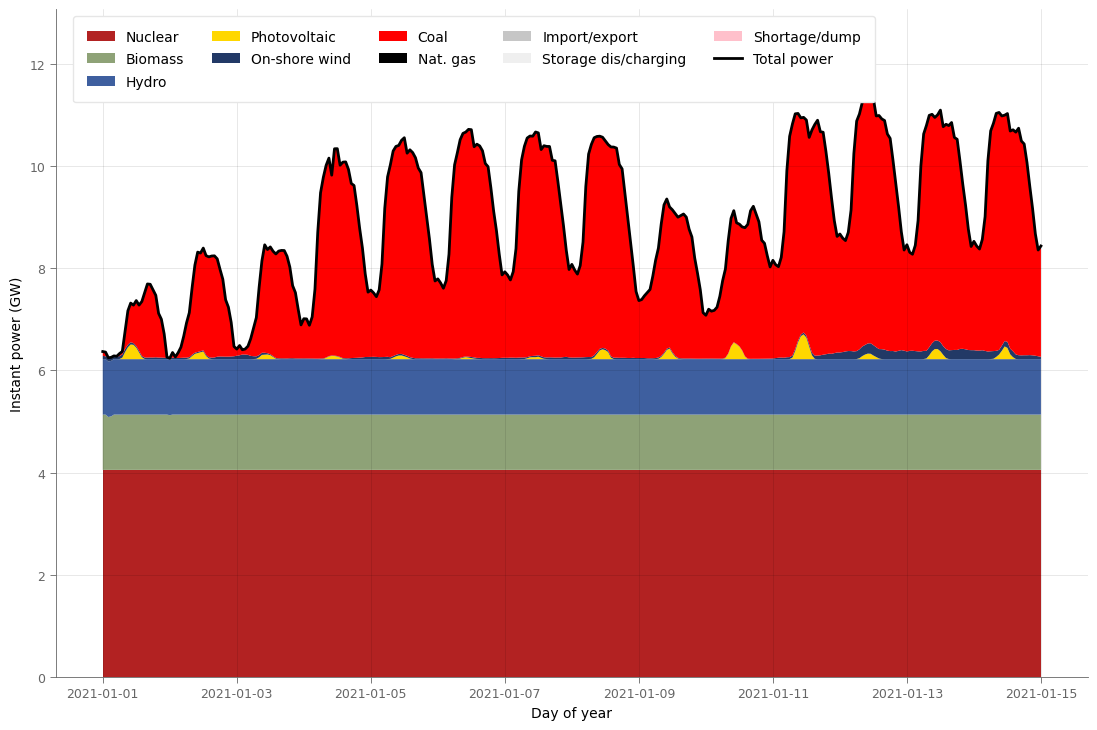

In [134]:
plot_between('2021-01-01', '2021-01-15')

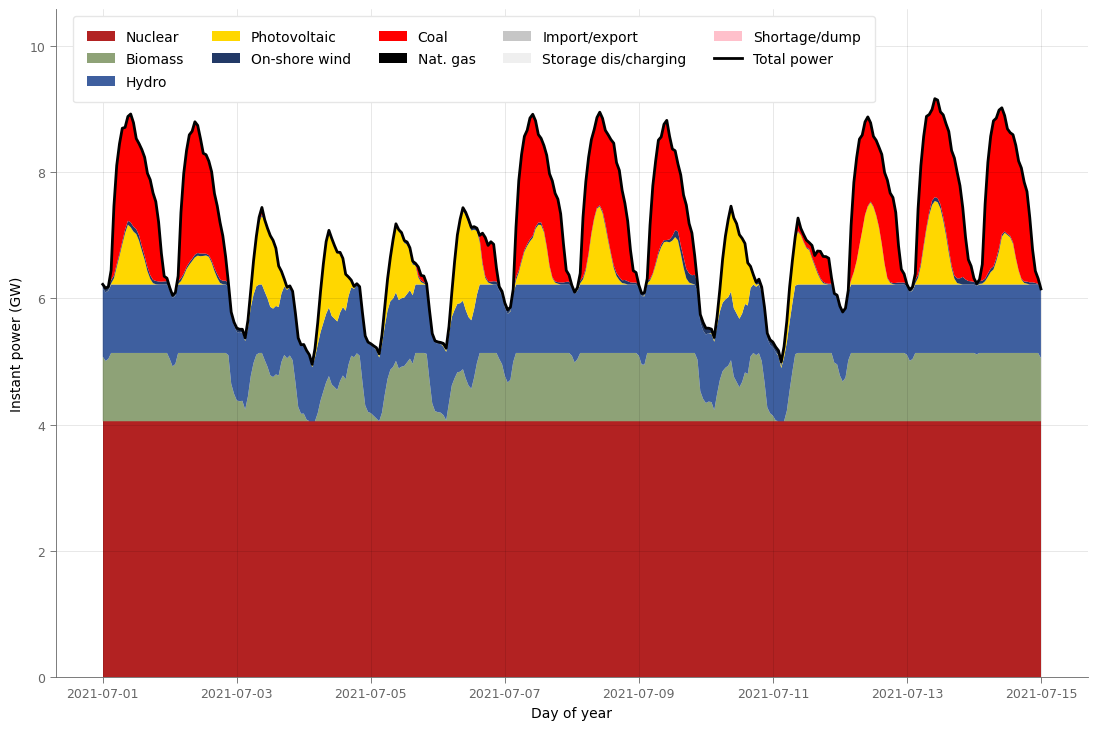

In [135]:
plot_between('2021-07-01', '2021-07-15')